# 01 — Storytelling  
## Student Performance Dataset (UCI)

### Objetivo

Construir uma narrativa orientada por dados para entender **quais fatores se associam ao desempenho escolar** e à **aprovação do aluno**.

Este notebook é focado em **exploração analítica e storytelling**, utilizando gráficos e métricas simples de associação.

O modelo de Machine Learning será desenvolvido separadamente no notebook **02_model_baseline.ipynb**.

---

### Dataset

- Fonte: Student Performance Dataset (UCI)
- Arquivo: `student-mat.csv`
- Separador: `;`
- Intervalo das notas: `0` a `20`

---

### Perguntas que queremos responder

1. Como é a distribuição das notas ao longo do tempo (`G1`, `G2`, `G3`)?
2. Quais fatores mais se relacionam com a nota final?
3. Quais variáveis se associam à aprovação ou reprovação?
4. Quais variáveis fazem sentido levar para um modelo baseline?


## Importação de bibliotecas e carregamento de dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, pointbiserialr

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)


## 1. Carregamento dos dados

O dataset utiliza `;` como separador.  
Não há valores ausentes explícitos neste arquivo, mas é importante validar tipos e consistência.


In [2]:
DATA_PATH = "data/student-mat.csv"  # ajuste se necessário
df = pd.read_csv(DATA_PATH, sep=";")

In [3]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


## 2. Visão geral do dataset

Antes de qualquer análise, vamos entender:
- Dimensão do dataset
- Tipos das colunas
- Presença de valores nulos


In [5]:
print("Shape:", df.shape)
display(df.dtypes)

Shape: (395, 33)


school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

In [6]:
nulls = df.isna().mean().sort_values(ascending=False)
nulls[nulls > 0]

Series([], dtype: float64)

## 3. Definição do problema de Machine Learning

O dataset contém três notas:
- `G1`: nota do 1º período
- `G2`: nota do 2º período
- `G3`: nota final

Para facilitar a análise e permitir um modelo simples e interpretável, definimos um problema de **classificação binária**:

- `target_pass = 1` se `G3 >= 10` (aluno aprovado)
- `target_pass = 0` se `G3 < 10` (aluno reprovado)

Esse threshold é comum em análises desse dataset e representa um critério mínimo de aprovação.


In [7]:
df["target_pass"] = (df["G3"] >= 10).astype(int)
df["target_pass"].value_counts(normalize=True)


target_pass
1    0.670886
0    0.329114
Name: proportion, dtype: float64

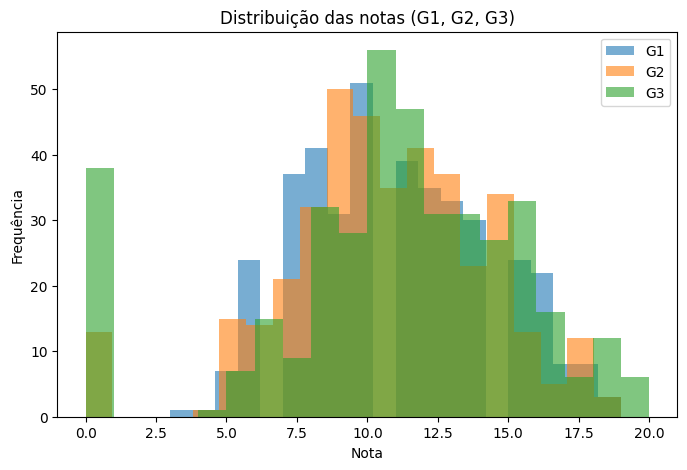

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(df["G1"], bins=20, alpha=0.6, label="G1")
plt.hist(df["G2"], bins=20, alpha=0.6, label="G2")
plt.hist(df["G3"], bins=20, alpha=0.6, label="G3")
plt.title("Distribuição das notas (G1, G2, G3)")
plt.xlabel("Nota")
plt.ylabel("Frequência")
plt.legend()
plt.show()


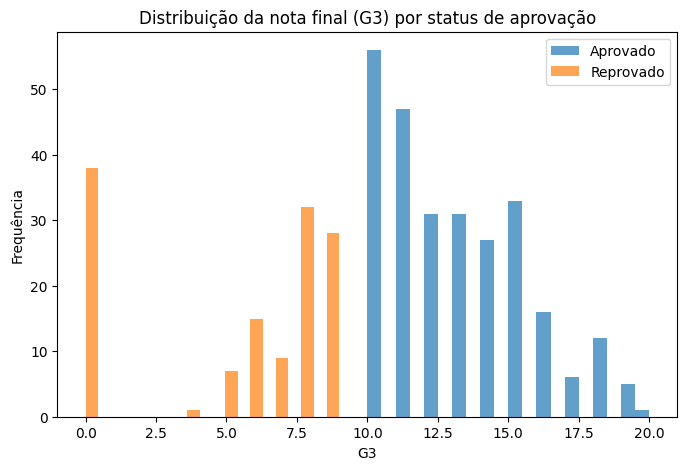

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(df[df["target_pass"] == 1]["G3"], bins=20, alpha=0.7, label="Aprovado")
plt.hist(df[df["target_pass"] == 0]["G3"], bins=20, alpha=0.7, label="Reprovado")
plt.title("Distribuição da nota final (G3) por status de aprovação")
plt.xlabel("G3")
plt.ylabel("Frequência")
plt.legend()
plt.show()


## 5. Correlação entre variáveis numéricas e nota final

Utilizamos a correlação de Pearson para entender quais variáveis numéricas se associam mais fortemente com a nota final (`G3`).

Essa análise serve para **ranqueamento de sinais**, não para inferência causal.


In [10]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()
corr["G3"].sort_values(ascending=False)

G3             1.000000
G2             0.904868
G1             0.801468
target_pass    0.770042
Medu           0.217147
Fedu           0.152457
studytime      0.097820
famrel         0.051363
absences       0.034247
freetime       0.011307
Walc          -0.051939
Dalc          -0.054660
health        -0.061335
traveltime    -0.117142
goout         -0.132791
age           -0.161579
failures      -0.360415
Name: G3, dtype: float64

## 6. Variáveis explicativas e desempenho

Vamos analisar algumas variáveis conhecidas por influenciar desempenho escolar:

- Tempo de estudo (`studytime`)
- Reprovações anteriores (`failures`)
- Faltas (`absences`)
- Tempo de deslocamento (`traveltime`)

A análise será feita por meio da **média da nota final por categoria**.


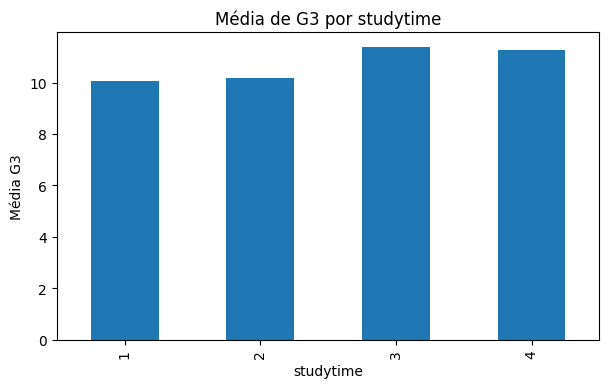

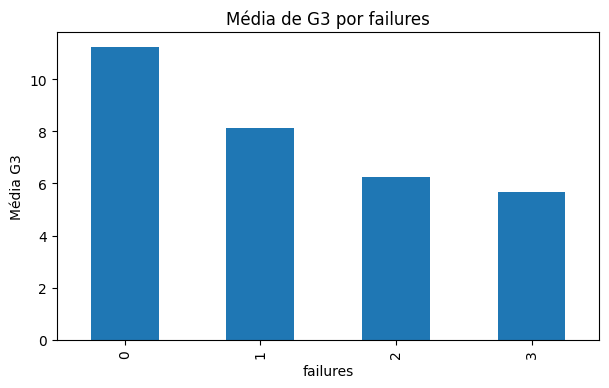

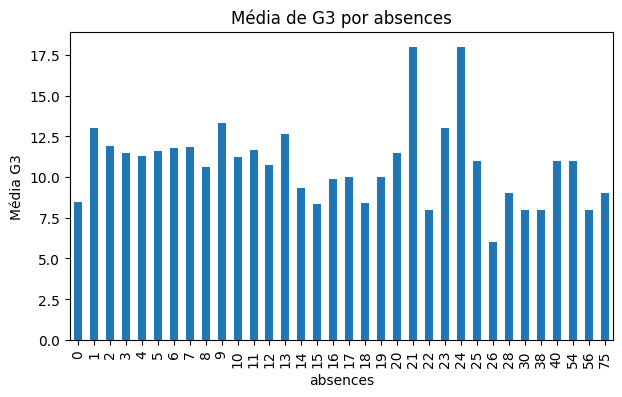

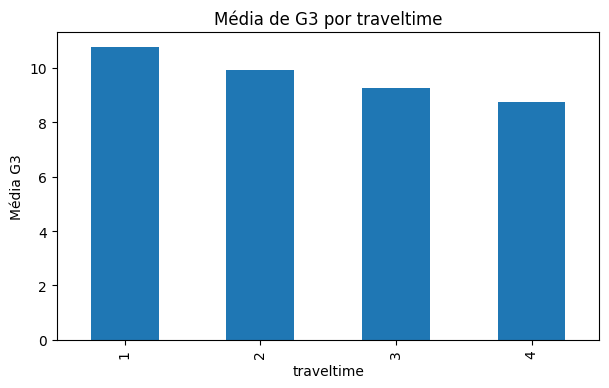

In [11]:
def mean_g3_by(col):
    return df.groupby(col)["G3"].mean()

for col in ["studytime", "failures", "absences", "traveltime"]:
    mean_g3_by(col).plot(kind="bar", figsize=(7, 4), title=f"Média de G3 por {col}")
    plt.ylabel("Média G3")
    plt.show()


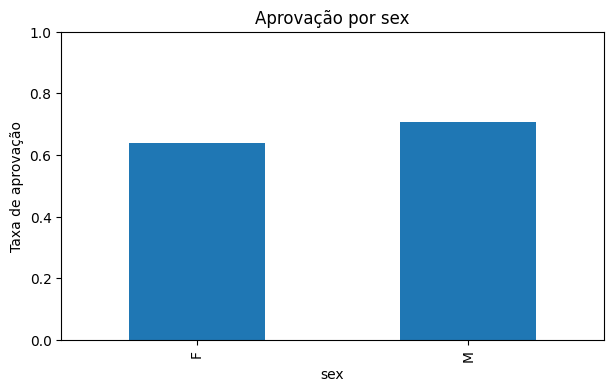

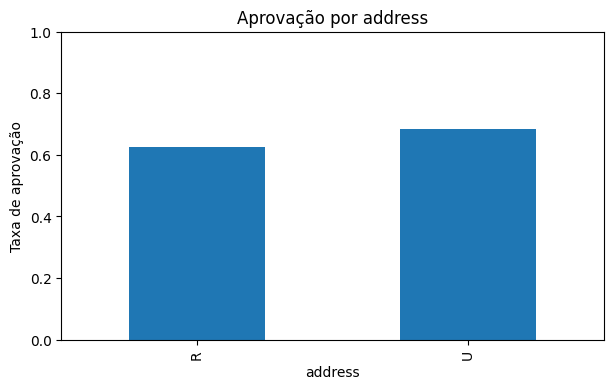

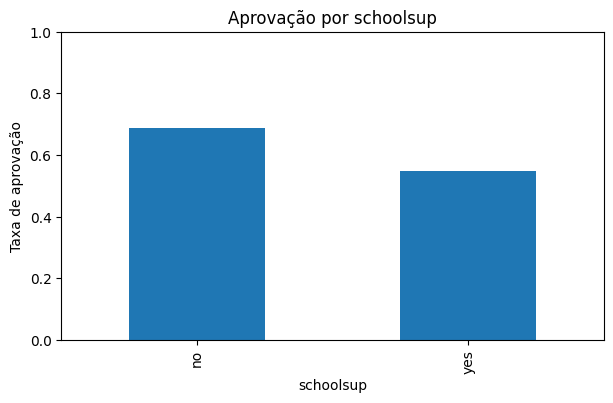

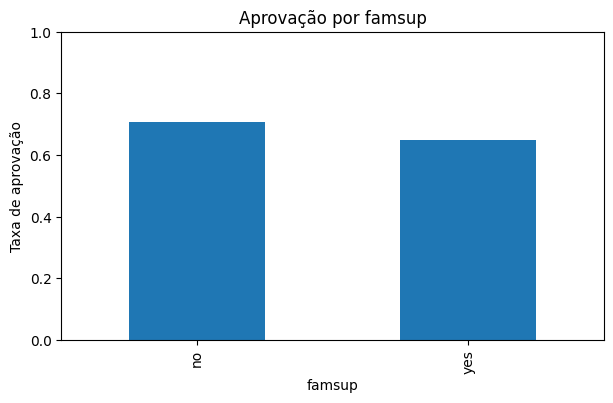

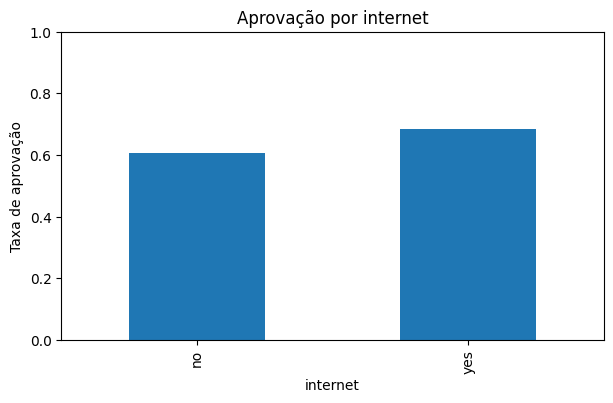

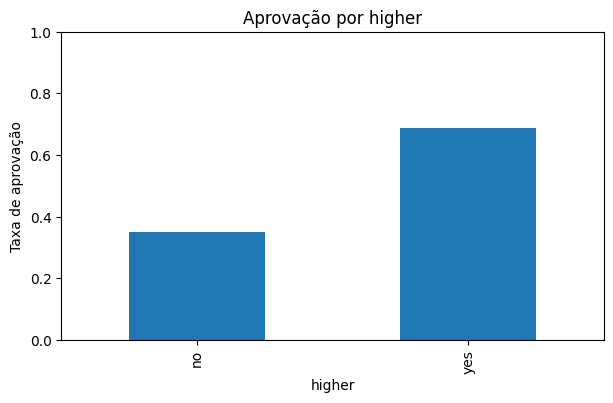

In [13]:
def approval_rate_by(col):
    return df.groupby(col)["target_pass"].mean()

for col in ["sex", "address", "schoolsup", "famsup", "internet", "higher"]:
    approval_rate_by(col).plot(kind="bar", figsize=(7, 4), title=f"Aprovação por {col}")
    plt.ylim(0, 1)
    plt.ylabel("Taxa de aprovação")
    plt.show()


## 9. Recorte final para o modelo baseline

Com base na análise exploratória, definimos:

**Target**
- `target_pass`

**Features**
- Todas as variáveis exceto `G1`, `G2` e `G3`

A exclusão das notas intermediárias evita vazamento temporal e força o modelo a aprender padrões socioeconômicos e comportamentais.


## 10. Síntese dos principais insights

*(Preencher após rodar e analisar os gráficos)*

- A distribuição das notas mostra que ...
- Variáveis como `studytime` e `failures` apresentam forte relação com a nota final.
- Fatores sociais e estruturais (apoio escolar, internet, ambiente familiar) também influenciam a taxa de aprovação.
- O problema de classificação binária (aprovado vs reprovado) é adequado, interpretável e alinhado ao objetivo do projeto.

No próximo notebook (**02_model_baseline.ipynb**), construiremos um pipeline simples de Machine Learning para validar esses achados.
